# Ramsy
> @author: Jiheng Duan

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import *
import pickle
# This on is a path correcting code, which is used to find the path of QuSim.
sys.path.append('../..')

import QuSim.System.transmon_system as qs
# Some useful tools
import QuSim.Instruments.tools as tools
# Some intrinsic plotting function
import QuSim.DataPlot.plot_lib as pl
from QuSim.PulseGen.noise_gen import noise_gen

# variable name -> string
def var_name2str(variable):
    def nested_var_name2str(value):
        if isinstance(value, list):
            return [nested_var_name2str(item) for item in value]
        else:
            for name in globals():
                if eval(name) == value:
                    return name
            return str(value)
    return nested_var_name2str(variable)

# auto reload
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Noise calculate

In [ ]:
from QuSim.PulseGen.noise_gen import noise_gen

tstart= 0; tstop = 600; tstep = 10000
tlist = np.linspace(tstart, tstop, tstep)
noise_config = {
'type': 'gaussian',
'switch': 'on',
'mean': 0,
'std': 20e-3
}

noise_config = {
'type': '1/f',
'switch': 'on',
'scale': 4,
'alpha': 1.2,
}

# repeat_time = 10000
# delta_phi = []
# for ii in tqdm(range(repeat_time)):
#     noise_seq = noise_gen(tstart, tstop, tstep, noise_config)
#     delta_phi.append(np.trapz(y=noise_seq, x=tlist))

# complex_exponentials = np.exp(1j * np.array(delta_phi))
# expectation_value = np.mean(complex_exponentials)
# expectation_value = np.exp(-1j * np.mean(np.array(delta_phi))/2)
# print("The expectation value is:", expectation_value)
noise_seq = noise_gen(tstart, tstop, tstep, noise_config)
plt.plot(tlist, noise_seq)

# Setup system

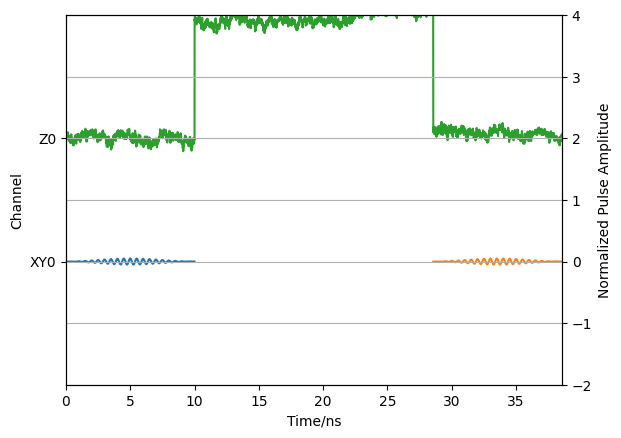

0

In [2]:
N = None # Maximum excitation level
w = [2] # Qubit frequency
q_dim = [2 for _ in range(len(w))]
alpha =[-0.3] # Anharmonicity

_system = qs.qubit_system(N, q_dim, w, alpha)

state_0, E_0, index_0 = _system.get_eigenstates_energy((0,))
state_1, E_1, index_1 = _system.get_eigenstates_energy((1,))

tg_half_pi = 10; amp_half_pi = 1/(2*tg_half_pi)
tau_wait = 18.56; t_total = 2*tg_half_pi + tau_wait

simulation_option = {
    "simulation_time": t_total, # Unit in ns
    "simulation_step": int(t_total)*100,
    "initial_state": [state_0, state_1] # Do multiple simulation
}

# noise_chan1 = [
#     {
#     'type': 'gaussian',
#     'switch': 'on',
#     'mean': 0,
#     'std': 1/(85),
#     }
# ]

noise_chan1 = [
    {
    'type': '1/f',
    'switch': 'on',
    'scale': 0.1,
    'alpha': 1.2,
    }
]

pulse_sequence = [
    {
        'pulse_index': 0,
        'type': "XY", # 'XY' or 'Z'
        'pulse_shape': "cosine", # See PulseGen/pulse_shape.py
        't_delay': 0, # unit in ns
        't_width': tg_half_pi, # unit in ns
        't_plateau': 0, # unit in ns
        'freq': E_1 - E_0, # unit in GHz; Z pulse does not use it
        'pulse_detuning': 0,
        'phase': 0, # unit in rad;
        'amplitude': amp_half_pi, # XY: Rabi freq; Z: biased frequency
        'q_index': 0 # 0, 1, 2
    },
    {
        'pulse_index': 1,
        'type': "XY", # 'XY' or 'Z'
        'pulse_shape': "cosine", # See PulseGen/pulse_shape.py
        't_delay': tau_wait+tg_half_pi, # unit in ns
        't_width': tg_half_pi, # unit in ns
        't_plateau': 0, # unit in ns
        'freq': E_1 - E_0, # unit in GHz; Z pulse does not use it
        'pulse_detuning': 0,
        'phase': 0, # unit in rad;
        'amplitude': amp_half_pi, # XY: Rabi freq; Z: biased frequency
        'q_index': 0 # 0, 1, 2
    },
    {
        'pulse_index': 2,
        'type': "Z", # 'XY' or 'Z'
        'pulse_shape': "square", # See PulseGen/pulse_shape.py
        't_delay': tg_half_pi, # unit in ns
        't_width': tau_wait, # unit in ns
        't_plateau': 0, # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'pulse_detuning': 0,
        'phase': 0, # unit in rad;
        'amplitude': w[0], # XY: Rabi freq; Z: biased frequency
        'q_index': 0,
        'noise': noise_chan1
    },
    # {
    #     'pulse_index': 3,
    #     'type': "Z", # 'XY' or 'Z'
    #     'pulse_shape': "square", # See PulseGen/pulse_shape.py
    #     't_delay': tg_half_pi, # unit in ns
    #     't_width': tau_wait, # unit in ns
    #     't_plateau': 0, # unit in ns
    #     'freq': 0, # unit in GHz; Z pulse does not use it
    #     'pulse_detuning': 0,
    #     'phase': 0, # unit in rad;
    #     'amplitude': 0, # XY: Rabi freq; Z: biased frequency
    #     'q_index': 0,
    #     'noise': noise_chan1
    # },
]
pl.plot_pulse_sequence(pulse_sequence, simulation_option)

In [259]:
result_list, angle_list = _system.system_dynamics_mesolve(simulation_option, pulse_sequence)

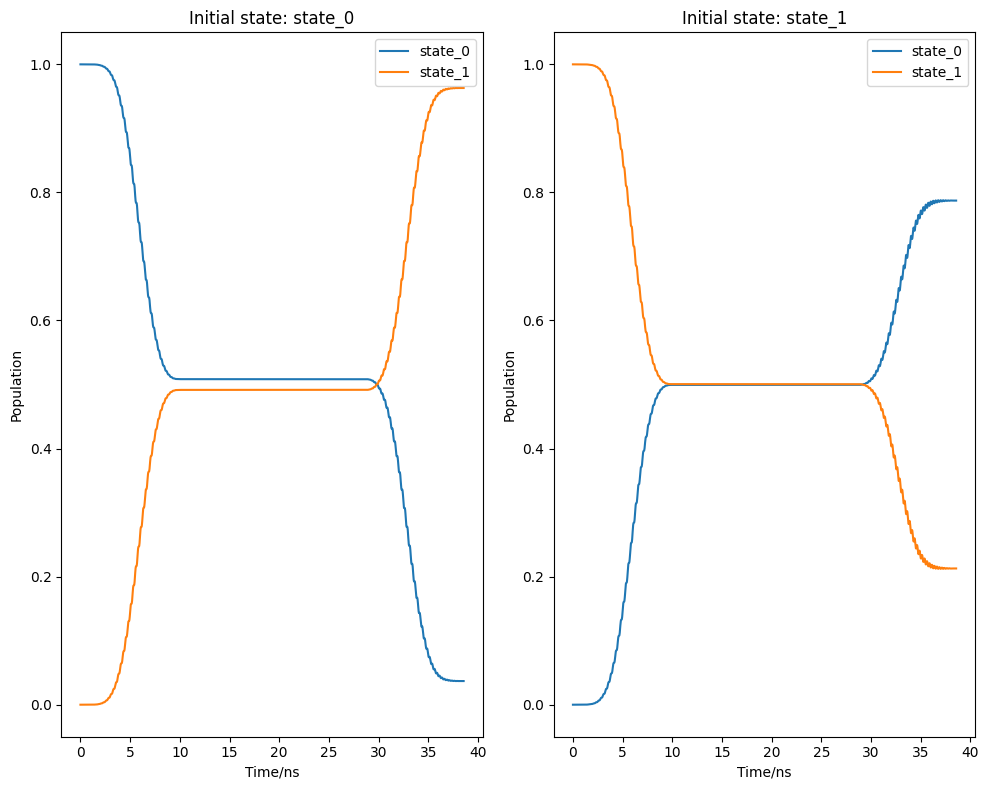

0

In [260]:
# state that you want to plot each simulation
interested_state = [
                    [state_0, state_1],
                    [state_0, state_1],
                    ]
# Convert the variable name to string in order to make legend in the plot
interested_state_label = var_name2str(interested_state)
initial_state_label = var_name2str(simulation_option["initial_state"])
%matplotlib inline
# plot state population evolution
pl.plot_population_evolution(_system, result_list, simulation_option, interested_state, interested_state_label, initial_state_label)

In [7]:
noise_chan1 = [
    {
    'type': 'gaussian',
    'switch': 'on',
    'mean': 0,
    'std': 1/(100),
    }
]

repeat_time = 50
tau_list = np.linspace(0, 500, 250)
ramsy_pop = []
tg_half_pi = 10; amp_half_pi = 1/(2*tg_half_pi)

for tau_d in tqdm(tau_list):
    tau_wait = tau_d; t_total = 2*tg_half_pi + tau_wait
    simulation_option = {
        "simulation_time": t_total, # Unit in ns
        "simulation_step": int(t_total)*80,
        "initial_state": [state_0] # Do multiple simulation
    }

    pulse_sequence = [
        {
            'pulse_index': 0,
            'type': "XY", # 'XY' or 'Z'
            'pulse_shape': "cosine", # See PulseGen/pulse_shape.py
            't_delay': 0, # unit in ns
            't_width': tg_half_pi, # unit in ns
            't_plateau': 0, # unit in ns
            'freq': E_1 - E_0, # unit in GHz; Z pulse does not use it
            'pulse_detuning': 0,
            'phase': 0, # unit in rad;
            'amplitude': amp_half_pi, # XY: Rabi freq; Z: biased frequency
            'q_index': 0 # 0, 1, 2
        },
        {
            'pulse_index': 1,
            'type': "XY", # 'XY' or 'Z'
            'pulse_shape': "cosine", # See PulseGen/pulse_shape.py
            't_delay': tau_wait+tg_half_pi, # unit in ns
            't_width': tg_half_pi, # unit in ns
            't_plateau': 0, # unit in ns
            'freq': E_1 - E_0, # unit in GHz; Z pulse does not use it
            'pulse_detuning': 0,
            'phase': 0, # unit in rad;
            'amplitude': amp_half_pi, # XY: Rabi freq; Z: biased frequency
            'q_index': 0 # 0, 1, 2
        },
        {
            'pulse_index': 2,
            'type': "Z", # 'XY' or 'Z'
            'pulse_shape': "square", # See PulseGen/pulse_shape.py
            't_delay': tg_half_pi, # unit in ns
            't_width': tau_wait, # unit in ns
            't_plateau': 0, # unit in ns
            'freq': 0, # unit in GHz; Z pulse does not use it
            'pulse_detuning': 0,
            'phase': 0, # unit in rad;
            'amplitude': 25e-3, # XY: Rabi freq; Z: biased frequency
            'q_index': 0,
            'noise': noise_chan1
        },]
    initial0_track0 = []
    for trial in tqdm(range(repeat_time), leave=False):
        result_list, _ = _system.system_dynamics_mesolve(simulation_option, pulse_sequence)
        initial0_track0.append( np.abs( (state_0.dag() * result_list[0].states[-1]).data[0,0] ))
    ramsy_pop.append(np.average(initial0_track0))

  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [5:08:40<00:00, 74.08s/it]   


In [8]:
data = [ramsy_pop, tau_list,tg_half_pi, repeat_time]

trail =3
pickle.dump(data, open(f'../../Data/Qfactor_ramsy_transmon_{trail}.pkl', 'wb'))

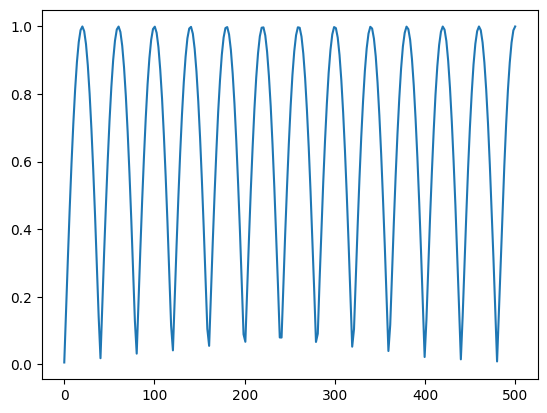

In [9]:
trail =3
ramsy_pop, tau_list,tg_half_pi, repeat_time= pickle.load(open(f'../../Data/Qfactor_ramsy_transmon_{trail}.pkl', 'rb'))
plt.plot(tau_list,ramsy_pop)
plt.show()